In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

DELETION_TYPE = 'long' # TODO 
# DELETION_TYPE = 'all' # TODO 

LARGE_WINDOWS_CSV = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/large-windows-with-{DELETION_TYPE}-deletions-intersect-small-windows.aggregated.csv'

import numpy as np 

DELETION_COUNT_THRESHOLDS = np.arange(0, 20, 2)

ZSCORE_NAMES = [
  'negative new chen zscore',
  'min negative new chen zscore',
]

ZSCORE_THRESHOLDS = [
  np.arange(-25, 20, 2),
  np.arange(-7, 0, 0.5),
]

EXPERIMENT = 1

BALANCE_CLASSES = True

In [2]:
import pandas as pd 

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

## Large windows with overlapping deletions and Chen scores

In [3]:
def read_large_windows():
  # experiments/germline-model/chen-et-al-2022/deletion-density.1.ipynb
  df = pd.read_csv(LARGE_WINDOWS_CSV, sep=',')  
  return df 

read_large_windows() 

,chrom_large,start_large,end_large,number_of_overlapping_topmed_deletions,large_window-merged_deletion overlap,sum small_window overlaps merged_exon,sum small_window overlaps enhancer,sum small_window overlaps cpg_island,sum N_observed,sum enhancer count,sum small_window_enhancer_overlap_bps sum,sum N_mean_null_chen,sum N_variance_null_chen,sum large_window-small_window overlap,min negative new chen zscore,negative new chen zscore
0,chr1,2300000,2400000,4,60303,21,13,7,8177,14,9337,9794.714649,9794.714649,31000,-6.254506,-16.345794
1,chr1,2400000,2500000,2,74431,4,4,1,3093,4,1798,3866.251388,3866.251388,13000,-6.184123,-12.435855
2,chr1,2500000,2600000,1,2537,22,21,11,7172,24,17979,9340.543817,9340.543817,28000,-8.252822,-22.437895
3,chr1,2600000,2700000,3,37639,5,2,0,3669,2,1037,4376.598388,4376.598388,18000,-5.443687,-10.695928
4,chr1,2800000,2900000,6,63623,3,6,0,6183,6,2048,7225.712275,7225.712275,25000,-4.825689,-12.266599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24628,chr9,133900000,134000000,10,88278,3,25,3,7476,27,19573,9422.773366,9422.773366,32000,-5.783680,-20.055155
24629,chr9,134000000,134100000,2,100000,11,11,2,7910,12,6989,9103.134739,9103.134739,37000,-5.149057,-12.505297
24630,chr9,134200000,134300000,8,82201,5,25,0,10653,27,18569,13194.622097,13194.622097,47000,-5.052936,-22.126489
24631,chr9,134300000,134400000,0,0,1,18,2,5128,21,13587,6424.429486,6424.429486,22000,-6.073125,-16.174528


## Critical and noncritical genes

In [4]:
def read_critical_genes():
  df = pd.read_csv(
    f"{CONSTRAINT_TOOLS_DATA}/genes/grch38/critical.genes.sorted.bed", 
    sep = '\t',
    header=None,
    names=['chrom', 'start', 'end', 'gene'],
  )  
  return df 

read_critical_genes().head()

,chrom,start,end,gene
0,chr1,6785454,7769706,CAMTA1
1,chr1,10210570,10381603,KIF1B
2,chr1,11012344,11030528,TARDBP
3,chr1,11273198,11296049,UBIAD1
4,chr1,11845709,11848345,NPPA


In [5]:
def read_noncritical_genes():
  df = pd.read_csv(
    f"{CONSTRAINT_TOOLS_DATA}/genes/grch38/noncritical.genes.sorted.bed", 
    sep = '\t',
    header=None,
    names=['chrom', 'start', 'end', 'gene'],
  )  
  return df 

read_noncritical_genes().head()

,chrom,start,end,gene
0,chr1,65419,71585,OR4F5
1,chr1,450740,451678,OR4F29
2,chr1,685716,686654,OR4F16
3,chr1,923923,944575,SAMD11
4,chr1,944203,959309,NOC2L


## Compute number of critical and noncritical genes that overlap each large window, and filter out windows accordingly


In [6]:
from shell import shell

# binary classification 
def compute_true_constraint(row): 
  if row['critical_gene_count'] > 0: 
    return True
  elif row['gene_counts'] == (0, 0):
    return False
  else: 
    raise ValueError(f'Unexpected gene counts: {row["gene_counts"]}')
  
def intersect_large_windows_with_critical_and_noncritical_genes():
  large_windows_with_critical_gene_counts = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/large-windows-with-{DELETION_TYPE}-deletions-intersect-small-windows-with-gene-counts.bed'
  cmd = (
    f'bedtools intersect'
    f" -a <(python create_bed_file_of_large_windows.py {LARGE_WINDOWS_CSV})"
    f" -b" 
    f" {CONSTRAINT_TOOLS_DATA}/genes/grch38/critical.genes.sorted.bed"
    f" {CONSTRAINT_TOOLS_DATA}/genes/grch38/noncritical.genes.sorted.bed"
    f' -names critical noncritical'
    f' -C'
    f' -f 0.1'
    f' | sort -k1,1V -k2,2n'
    f' > {large_windows_with_critical_gene_counts}'
  )
  shell(cmd)

  with open(LARGE_WINDOWS_CSV) as f: 
    index = f.readline().strip().split(',')

  df = pd.read_csv(
    large_windows_with_critical_gene_counts, 
    sep='\t',
    names=index + ['gene_class', 'number_of_overlapping_genes'],
  )
  df = df.pivot(
    index=index, 
    columns='gene_class', 
    values='number_of_overlapping_genes'
  ) 
  df = df.rename(columns={'critical': 'critical_gene_count', 'noncritical': 'noncritical_gene_count'})
  df = df.reset_index()
  df = df.rename_axis('index', axis=1) # rename index column

  df['gene_counts'] = list(zip(df['critical_gene_count'], df['noncritical_gene_count']))
  
  print('gene counts (critical, noncritical) and number of windows')
  print(df['gene_counts'].value_counts())

  positive_examples = df[df['critical_gene_count'] > 0]

  negative_examples = df[df['gene_counts'] == (0, 0)]
  if BALANCE_CLASSES:
    negative_examples = negative_examples.sample(n=len(positive_examples), random_state=0) # balance classes for later training 

  df = pd.concat([negative_examples, positive_examples])

  df['true_constraint'] = df.apply(compute_true_constraint, axis=1)

  return df 

LABELED_EXAMPLES = intersect_large_windows_with_critical_and_noncritical_genes()
LABELED_EXAMPLES


gene counts (critical, noncritical) and number of windows
(0, 1)     10021
(0, 0)      9404
(0, 2)      3045
(0, 3)       912
(1, 0)       625
(1, 1)       275
(0, 4)       174
(1, 2)        79
(0, 5)        33
(1, 3)        26
(2, 0)        10
(1, 4)         6
(2, 2)         5
(2, 1)         4
(0, 6)         4
(0, 7)         2
(0, 15)        2
(2, 3)         1
(0, 10)        1
(0, 13)        1
(0, 12)        1
(0, 22)        1
(1, 22)        1
Name: gene_counts, dtype: int64


index,chrom_large,start_large,end_large,number_of_overlapping_topmed_deletions,large_window-merged_deletion overlap,sum small_window overlaps merged_exon,sum small_window overlaps enhancer,sum small_window overlaps cpg_island,sum N_observed,sum enhancer count,sum small_window_enhancer_overlap_bps sum,sum N_mean_null_chen,sum N_variance_null_chen,sum large_window-small_window overlap,min negative new chen zscore,negative new chen zscore,critical_gene_count,noncritical_gene_count,gene_counts,true_constraint
5513,chr12,103000000,103100000,1,10216,4,12,0,15070,12,7300,14502.976065,14502.976065,76000,-1.481887,4.708394,0,0,"(0, 0)",False
8747,chr16,73900000,74000000,0,0,8,11,0,20085,11,3799,17515.940416,17515.940416,86000,-1.172854,19.411426,0,0,"(0, 0)",False
12565,chr2,200100000,200200000,5,100000,0,36,0,15381,36,26021,16360.081989,16360.081989,83000,-3.314121,-7.654667,0,0,"(0, 0)",False
23468,chr8,126200000,126300000,1,10073,0,2,0,13217,3,904,13091.722332,13091.722332,66000,-1.997915,1.094902,0,0,"(0, 0)",False
22983,chr8,77500000,77600000,18,100000,7,5,0,14807,5,947,12395.144536,12395.144536,69000,0.368207,21.663343,0,0,"(0, 0)",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24574,chr9,128500000,128600000,1,18668,37,25,4,11539,25,19817,13252.128138,13252.128138,61000,-4.578077,-14.881511,1,1,"(1, 1)",True
24575,chr9,128600000,128700000,0,0,27,19,4,8532,20,14435,9526.314064,9526.314064,41000,-4.902562,-10.187348,1,2,"(1, 2)",True
24587,chr9,129800000,129900000,0,0,24,35,7,10085,37,27353,11784.166655,11784.166655,49000,-5.845668,-15.652602,1,2,"(1, 2)",True
24618,chr9,132900000,133000000,1,7674,37,35,2,13863,42,21415,16458.677621,16458.677621,73000,-6.161456,-20.232674,1,1,"(1, 1)",True


## SNV-only, SV-only, and SNV+SV classifiers 

In [7]:
def predict_constraint_using_SNVs(df, zscore_threshold): 
  df = df[[ZSCORE_NAMES[EXPERIMENT], 'true_constraint']].copy()
  df['predicted to be constrained'] = df[ZSCORE_NAMES[EXPERIMENT]] < zscore_threshold
  return df

predict_constraint_using_SNVs(LABELED_EXAMPLES, zscore_threshold=-6)

index,min negative new chen zscore,true_constraint,predicted to be constrained
5513,-1.481887,False,False
8747,-1.172854,False,False
12565,-3.314121,False,False
23468,-1.997915,False,False
22983,0.368207,False,False
...,...,...,...
24574,-4.578077,True,False
24575,-4.902562,True,False
24587,-5.845668,True,False
24618,-6.161456,True,True


In [8]:
def predict_constraint_using_SVs(df, deletion_count_threshold): 
  df = df[[
    'number_of_overlapping_topmed_deletions',
    'true_constraint', 
  ]].copy()
  df['predicted to be constrained'] = df['number_of_overlapping_topmed_deletions'] <= deletion_count_threshold
  return df

pd.set_option('display.max_rows', 10)

predict_constraint_using_SVs(LABELED_EXAMPLES, deletion_count_threshold=5)

index,number_of_overlapping_topmed_deletions,true_constraint,predicted to be constrained
5513,1,False,True
8747,0,False,True
12565,5,False,True
23468,1,False,True
22983,18,False,False
...,...,...,...
24574,1,True,True
24575,0,True,True
24587,0,True,True
24618,1,True,True


In [9]:
def predict_constraint_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold): 
  df = df[[
    ZSCORE_NAMES[EXPERIMENT], 
    'number_of_overlapping_topmed_deletions',
    'true_constraint', 
  ]].copy()
  # majority voting ensemble (i.e. if both the SNV and SV model predict a region to be constrained, then it is predicted to be constrained)
  df['predicted to be constrained'] = (
    predict_constraint_using_SNVs(df, zscore_threshold)['predicted to be constrained'] & 
    predict_constraint_using_SVs(df, deletion_count_threshold)['predicted to be constrained']
  )
  # # "OR" ensemble (i.e. if either the SNV or SV model predicts a region to be constrained, then it is predicted to be constrained)
  # df['predicted to be constrained'] = (
  #   predict_constraint_using_SNVs(df, zscore_threshold)['predicted to be constrained'] |
  #   predict_constraint_using_SVs(df, deletion_count_threshold)['predicted to be constrained']
  # )
  return df 

pd.set_option('display.max_rows', 10)

predict_constraint_using_voting_ensemble(LABELED_EXAMPLES, zscore_threshold=-2, deletion_count_threshold=5)

index,min negative new chen zscore,number_of_overlapping_topmed_deletions,true_constraint,predicted to be constrained
5513,-1.481887,1,False,False
8747,-1.172854,0,False,False
12565,-3.314121,5,False,True
23468,-1.997915,1,False,False
22983,0.368207,18,False,False
...,...,...,...,...
24574,-4.578077,1,True,True
24575,-4.902562,0,True,True
24587,-5.845668,0,True,True
24618,-6.161456,1,True,True


In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

def predict_constraint_using_probabilistic_model(df, prob_threshold): 
  df = df[[
    ZSCORE_NAMES[EXPERIMENT], 
    'number_of_overlapping_topmed_deletions',
    'true_constraint', 
  ]].copy()

  X = df[[ZSCORE_NAMES[EXPERIMENT], 'number_of_overlapping_topmed_deletions']]
  y = df['true_constraint']

  # model = LinearDiscriminantAnalysis()
  # model = QuadraticDiscriminantAnalysis()
  model = LogisticRegression() 
  model.fit(X, y)
  df['predicted to be constrained'] = model.predict_proba(X)[:, 1] > prob_threshold

  return df 

pd.set_option('display.max_rows', 10)

predict_constraint_using_probabilistic_model(LABELED_EXAMPLES, prob_threshold=0.3)

index,min negative new chen zscore,number_of_overlapping_topmed_deletions,true_constraint,predicted to be constrained
5513,-1.481887,1,False,False
8747,-1.172854,0,False,False
12565,-3.314121,5,False,True
23468,-1.997915,1,False,True
22983,0.368207,18,False,False
...,...,...,...,...
24574,-4.578077,1,True,True
24575,-4.902562,0,True,True
24587,-5.845668,0,True,True
24618,-6.161456,1,True,True


In [11]:
def compute_precision_recall(df, log): 
  contingency_table = pd.crosstab(
    df['predicted to be constrained'], 
    df['true_constraint']
  )

  if log: print(contingency_table)

  tp = contingency_table.loc[True, True]
  fp = contingency_table.loc[True, False]
  fn = contingency_table.loc[False, True]
  precision = tp / (tp + fp) # type: ignore
  recall = tp / (tp + fn) # type: ignore

  return precision, recall

def compute_precision_recall_using_SNVs(df, zscore_threshold, log=False): 
  if log: print(zscore_threshold)
  df = predict_constraint_using_SNVs(df, zscore_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_SNVs(LABELED_EXAMPLES, zscore_threshold=-5, log=True)

-5
true_constraint              False  True
predicted to be constrained             
False                          998   782
True                            34   250


(0.8802816901408451, 0.24224806201550386)

In [12]:
def compute_precision_recall_using_SVs(df, deletion_count_threshold, log=False): 
  if log: print(deletion_count_threshold)
  df = predict_constraint_using_SVs(df, deletion_count_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_SVs(LABELED_EXAMPLES, deletion_count_threshold=5, log=True)

5
true_constraint              False  True
predicted to be constrained             
False                          401   108
True                           631   924


(0.5942122186495177, 0.8953488372093024)

In [13]:
def compute_precision_recall_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold, log=False): 
  if log: 
    print(zscore_threshold)
    print(deletion_count_threshold)
  df = predict_constraint_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_voting_ensemble(LABELED_EXAMPLES, zscore_threshold=-3, deletion_count_threshold=5, log=True)

-3
5
true_constraint              False  True
predicted to be constrained             
False                          842   361
True                           190   671


(0.7793263646922184, 0.6501937984496124)

In [14]:
def compute_precision_recall_using_probabilistic_model(df, prob_threshold, log=False): 
  if log: 
    print(prob_threshold)
  df = predict_constraint_using_probabilistic_model(df, prob_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_probabilistic_model(LABELED_EXAMPLES, prob_threshold=0.3, log=True)

0.3
true_constraint              False  True
predicted to be constrained             
False                          447    82
True                           585   950


(0.6188925081433225, 0.9205426356589147)

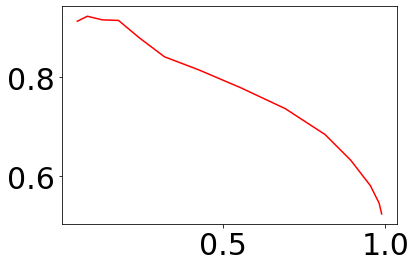

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font size
mpl.rcParams['font.size'] = 30

def plot_precision_recall_using_SNVs(df, zscore_thresholds): 
  precision_recall = [
    compute_precision_recall_using_SNVs(df, zscore_threshold, log=False)
    for zscore_threshold in zscore_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label='using SNVs', color='red')

plot_precision_recall_using_SNVs(
  LABELED_EXAMPLES, 
  zscore_thresholds=ZSCORE_THRESHOLDS[EXPERIMENT],
)

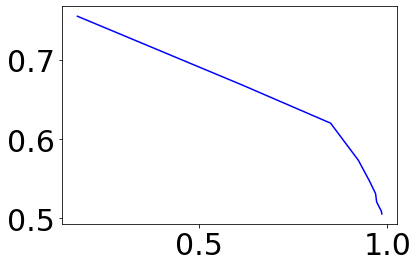

In [16]:
def plot_precision_recall_using_SVs(df, deletion_count_thresholds): 
  precision_recall = [
    compute_precision_recall_using_SVs(df, deletion_count_threshold, log=False)
    for deletion_count_threshold in deletion_count_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label='using SVs', color='blue')

plot_precision_recall_using_SVs(
  LABELED_EXAMPLES, 
  deletion_count_thresholds=DELETION_COUNT_THRESHOLDS
)

-7.0
0
true_constraint              False  True
predicted to be constrained             
False                         1031  1022
True                             1    10
-6.5
0
true_constraint              False  True
predicted to be constrained             
False                         1031  1016
True                             1    16
-6.0
0
true_constraint              False  True
predicted to be constrained             
False                         1031  1006
True                             1    26
-5.5
0
true_constraint              False  True
predicted to be constrained             
False                         1030   993
True                             2    39
-5.0
0
true_constraint              False  True
predicted to be constrained             
False                         1029   982
True                             3    50
-4.5
0
true_constraint              False  True
predicted to be constrained             
False                         1025   956
True           

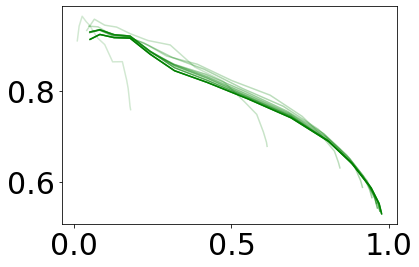

In [17]:
def plot_precision_recall_using_voting_ensemble(df, zscore_thresholds, deletion_count_thresholds): 
  alphas = np.logspace(-0.75, 0, len(deletion_count_thresholds))
  for index, (alpha, deletion_count_threshold) in enumerate(zip(alphas, deletion_count_thresholds)):
    precision_recall = [
      compute_precision_recall_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold, log=True)
      for zscore_threshold in zscore_thresholds
    ]
    precisions, recalls = zip(*precision_recall)
    if index == 0 or index == len(deletion_count_thresholds) - 1: 
      plt.plot(recalls, precisions, label=f'using SNVs and SVs (majority-vote ensemble)\n(deletion-count threshold = {deletion_count_thresholds[index]})', color='green', alpha=alpha)
    else:
      plt.plot(recalls, precisions, color='green', alpha=alpha)

plot_precision_recall_using_voting_ensemble(
  LABELED_EXAMPLES,
  zscore_thresholds = ZSCORE_THRESHOLDS[EXPERIMENT],
  deletion_count_thresholds = DELETION_COUNT_THRESHOLDS,
)

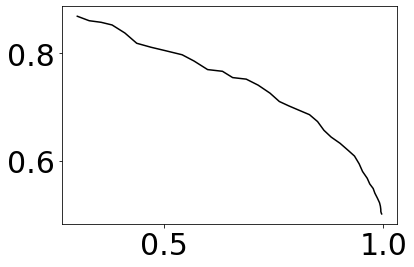

In [18]:
def plot_precision_recall_using_probabilistic_model(df, prob_thresholds): 
  precision_recall = [
    compute_precision_recall_using_probabilistic_model(df, prob_threshold, log=False)
    for prob_threshold in prob_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label='using probabilistic model', color='black')

plot_precision_recall_using_probabilistic_model(
  LABELED_EXAMPLES, 
  prob_thresholds=np.arange(0.02, 0.8, 0.02) 
)

-7.0
0
true_constraint              False  True
predicted to be constrained             
False                         1031  1022
True                             1    10
-6.5
0
true_constraint              False  True
predicted to be constrained             
False                         1031  1016
True                             1    16
-6.0
0
true_constraint              False  True
predicted to be constrained             
False                         1031  1006
True                             1    26
-5.5
0
true_constraint              False  True
predicted to be constrained             
False                         1030   993
True                             2    39
-5.0
0
true_constraint              False  True
predicted to be constrained             
False                         1029   982
True                             3    50
-4.5
0
true_constraint              False  True
predicted to be constrained             
False                         1025   956
True           

(array([-7. , -6.5, -6. , -5.5, -5. , -4.5, -4. , -3.5, -3. , -2.5, -2. ,
        -1.5, -1. , -0.5]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18]))

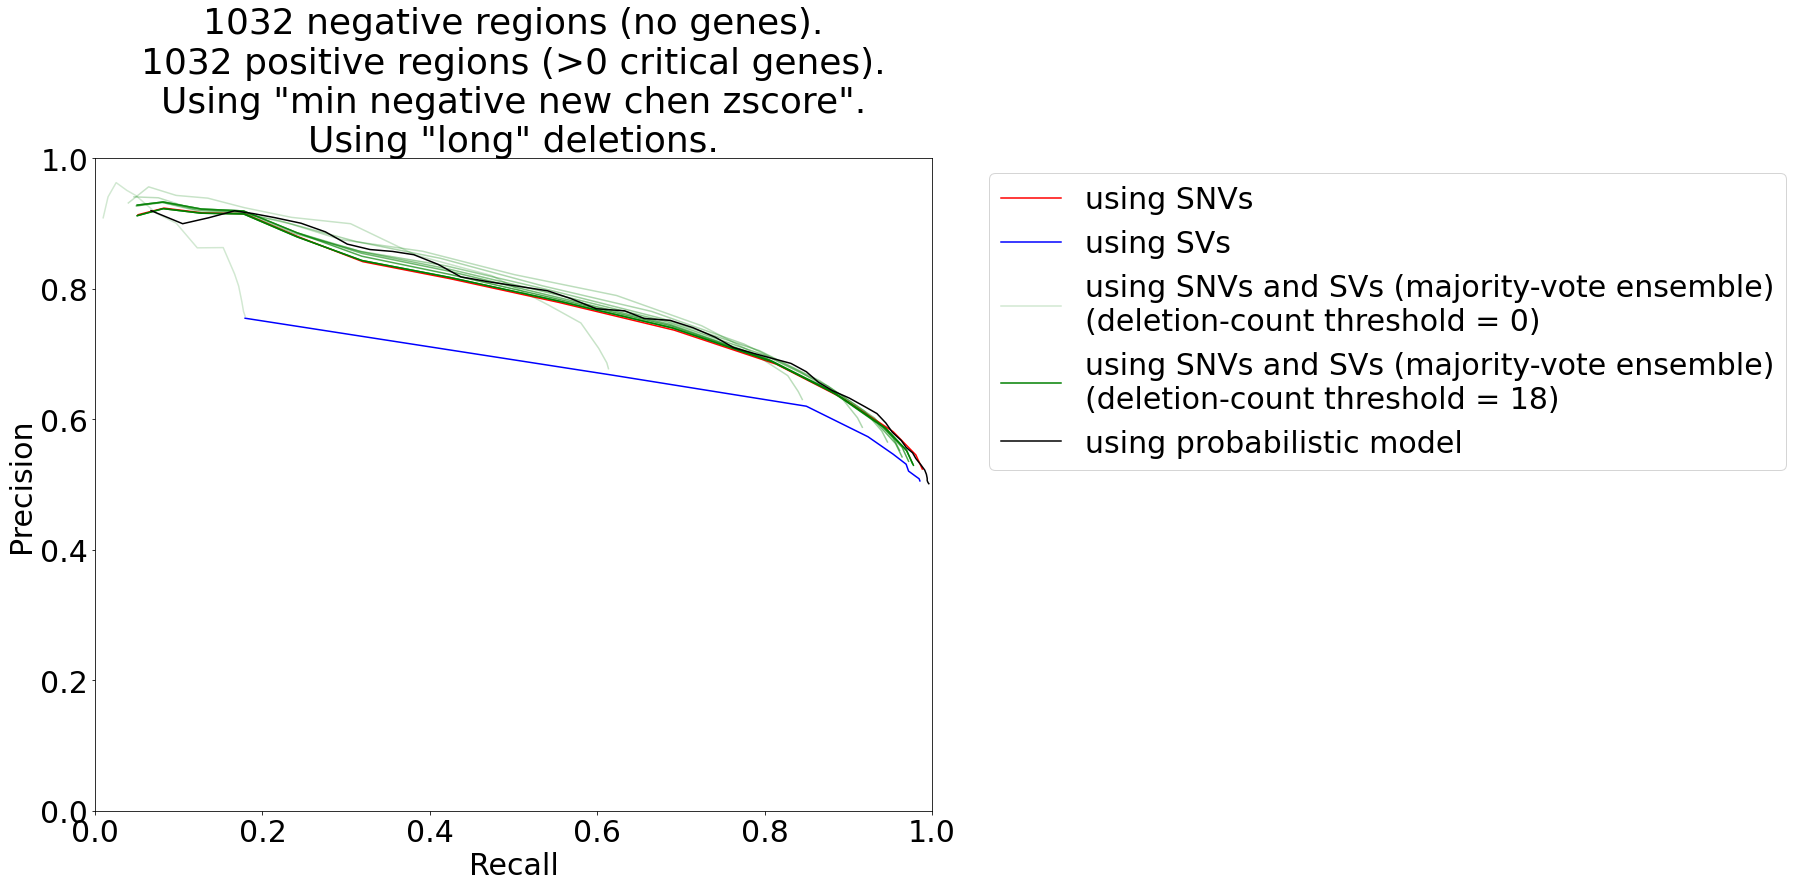

In [19]:
def plot_precision_recall_wrapper(df, zscore_thresholds, deletion_count_thresholds, prob_thresholds): 
  plot_precision_recall_using_SNVs(df, zscore_thresholds)
  plot_precision_recall_using_SVs(df, deletion_count_thresholds)
  plot_precision_recall_using_voting_ensemble(
    df, zscore_thresholds, deletion_count_thresholds
  )
  plot_precision_recall_using_probabilistic_model(df, prob_thresholds)  
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  fig = plt.gcf()
  fig.set_size_inches(15, 12)
  plt.xlim(0, 1)
  plt.ylim(0, 1)

  number_unconstrained_regions = df['true_constraint'].value_counts().loc[False]
  number_constrained_regions = df['true_constraint'].value_counts().loc[True]
  plt.title(
    f'{number_unconstrained_regions} negative regions (no genes).\n'
    f'{number_constrained_regions} positive regions (>0 critical genes).\n'
    f'Using "{ZSCORE_NAMES[EXPERIMENT]}".\n'
    f'Using "{DELETION_TYPE}" deletions.'
  )
  return zscore_thresholds, deletion_count_thresholds
  
plot_precision_recall_wrapper(
  LABELED_EXAMPLES,
  zscore_thresholds = ZSCORE_THRESHOLDS[EXPERIMENT],
  deletion_count_thresholds = DELETION_COUNT_THRESHOLDS,
  prob_thresholds = np.arange(0.02, 0.95, 0.02),
)